In [81]:
from dotenv import load_dotenv

load_dotenv()

True

In [82]:
# retrieve -> generate -> rewrite -> 문서 검증 
from langchain_chroma import Chroma 
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name="income_tax_collection",
    persist_directory="./income_tax_collection"
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})

In [83]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document 
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

graph_builder = StateGraph(AgentState)

In [84]:
def retrieve(state: AgentState):
    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}

In [85]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [86]:
from langchain_classic import hub


generate_prompt = hub.pull("rlm/rag-prompt")
generate_llm = ChatOpenAI(model="gpt-4o", max_completion_tokens=100)
def generate(state: AgentState):
    context = state['context']
    query = state['query']
    rag_chain = generate_prompt | generate_llm
    response = rag_chain.invoke({"question": query, "context": context})
    return {"answer": response}

In [87]:
from langchain_classic import hub
from typing import Literal 

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelevant']:
    query = state['query']
    context = state['context'] 
    print(f"context == {context}")
    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({"question": query, "documents": context})
    print(f'doc relevance response: {response}')
    if response['Score'] == 1:
        return 'relevant'
    return 'irrelevant'

In [88]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ["사람과 관련된 표현 -> 거주자"]

rewrite_prompt = PromptTemplate.from_template(f"""
        사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요.
        사전: {dictionary}
        wlfans: {{query}}
    """)

def rewrite(state: AgentState):
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({"query": query})
    return {"query": response}

In [89]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

hallucination_prompt = PromptTemplate.from_template("""
You are a teacher tasked with evaluating whether a student's answer is based on documents or not,
Given documents, which are excerpts from income tax law , and a student's answer;
Check whether the student's answer is hallucinated or not 
                                                    
If the student's answer is based on documents, respond with "not hallucinated",
If the student's answer is not based on documents, respond with "hallucinated".
documents: {documents}
student_answer: {student_answer}                                                    
""")

hallucination_llm = ChatOpenAI(model="gpt-4o", temperature=0)

def check_hallucination(state: AgentState) -> Literal['hallucinated', 'not hallucinated']:
    answer = state['answer']
    context = state['context']
    context = [doc.page_content for doc in context]
    
    hallucination_chain = hallucination_prompt | hallucination_llm | StrOutputParser()
    response = hallucination_chain.invoke({"student_answer": answer, "documents": context})
    return response

In [90]:
from langchain_classic import hub

helpfulness_prompt = hub.pull("langchain-ai/rag-answer-helpfulness")

def check_helpfulness_gragder(state: AgentState):
    query = state['query']
    answer = state['answer']
    helpfulness_chain = helpfulness_prompt | llm
    response = helpfulness_chain.invoke({"question": query, "student_answer": answer})
    print(f'helpfulness response: {response}')
    if response['Score'] == 1:
        return 'helpful'
    return 'unhelpful'

def check_helpfulness(state: AgentState):
    return state

In [91]:
query = "연봉 5천만원인 거주자의 소득세는 얼마인가요?"
context = retriever.invoke(query)
generate_state = {'query': query, 'context': context}
answer = generate(generate_state)

helpfulness_state = {'query': query, 'answer': answer}
check_helpfulness(helpfulness_state)

{'query': '연봉 5천만원인 거주자의 소득세는 얼마인가요?',
 'answer': {'answer': AIMessage(content='연봉 5천만원인 거주자의 소득세 계산을 위해서, 과세표준에 따른 세율을 적용해야 합니다. 5천만원 소득은 "8,800만원 이하" 구간에 해당하여, 624만원 + (5,000만원을 초과하는 금액의 24%)의 소득세가 부과됩니다. 여기서 정확한 소득세액은 소득 공제와 같은 상세한 세부사항 고려', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 3067, 'total_tokens': 3167, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 2944}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CTL9qtFFOEvI0atGCc6TSW3b0Cr5A', 'service_tier': 'default', 'finish_reason': 'length', 'logprobs': None}, id='lc_run--79d54ff2-42e2-4771-9897-33447bec3008-0', usage_metadata={'input_tokens': 3067, 'output_tokens': 100, 'total_tokens': 3167, 'input_token_details': {'audio': 0, 'cache_re

In [92]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)
graph_builder.add_node('check_helpfulness', check_helpfulness)

In [93]:
from langgraph.graph import START, END 

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges(
    'retrieve',
    check_doc_relevance,
    {
        'relevant': 'generate',
        'irrelevant': END
    }
)
graph_builder.add_conditional_edges(
    'generate',
    check_hallucination,
    {
        'not hallucinated': 'check_helpfulness',
        'hallucinated': 'generate'
    }
)

graph_builder.add_conditional_edges(
    'check_helpfulness',
    check_helpfulness_gragder,
    {
        'helpful': END,
        'unhelpful': 'rewrite'
    }
)
graph_builder.add_edge('rewrite', 'retrieve')

In [94]:
graph = graph_builder.compile()

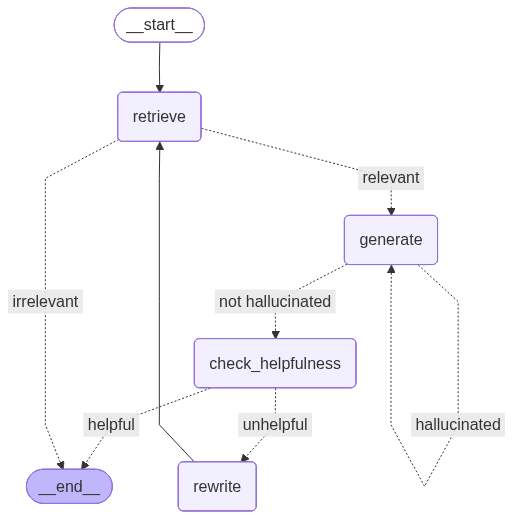

In [95]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [96]:
initial_state = {'query': '연봉 5천만원인 거주자가 납부해야 하는 소득세는 얼마인가요?'}
graph.invoke(initial_state)

context == [Document(id='52393066-41c6-4ad4-a248-652cc0d2eb3d', metadata={'source': './documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)\n10년 초과 20년 이하: 400만원 + 80만원 × (납입연수 - 10년)\n20년 초과: 1,200만원 + 120만원 × (납입연수 - 20년)\n\n② 직장근로자 초과관세환급금을 분배하여 지급받는 경우 세액의 계산 방법 등 필요한 사항은 대통령령으로 정한다. \n<대통령 2014. 12. 23.>\n<전문개정 2009. 12. 31.>\n제64조(부동산매매업자에 대한 세액 계산의 특례)\n1) 대통령령으로 정하는 부동산매매업(이하 “부동산매매업”이라 한다)을 영위하는 거주자가 이하 “부동산매매업자”라 한다)로서 종합소득세법에 제104조제1항제1호(본항을 포함한다) 및 제103조 또는 같은 조 제7항 각 호의 어느 하나에 해당하는 자산의 매매자익(이하 “주택등매매차익”이라 한다)이 있는 자의 종합소득 산출세액은 다음 각 호의 세액 중 많은 것으로 한다. \n<개정 2014. 12. 23., 2017. 12. 19., 2020. 12. 29.>\n1. 종합소득 산출세액\n\n다음 각 목에 따른 세액의 합계액\n  가. 주택등매매차익에 따른 세율을 적용하여 산출한 세액의 합계액\n  나. 종합소득세법 제55조에 따라 주택등매매차익에 대한 개별세액을 공제한 금액을 과세표준으로 하고 이에 제55조에 따른 세율을 적용하여 산출세액'), Document(id='53d6633d-8f39-4870-9faf-f2150e666992', metadata={'source': './documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (

{'query': '연봉 5천만원인 거주자가 납부해야 하는 소득세는 얼마인가요?',
 'context': [Document(id='52393066-41c6-4ad4-a248-652cc0d2eb3d', metadata={'source': './documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)\n10년 초과 20년 이하: 400만원 + 80만원 × (납입연수 - 10년)\n20년 초과: 1,200만원 + 120만원 × (납입연수 - 20년)\n\n② 직장근로자 초과관세환급금을 분배하여 지급받는 경우 세액의 계산 방법 등 필요한 사항은 대통령령으로 정한다. \n<대통령 2014. 12. 23.>\n<전문개정 2009. 12. 31.>\n제64조(부동산매매업자에 대한 세액 계산의 특례)\n1) 대통령령으로 정하는 부동산매매업(이하 “부동산매매업”이라 한다)을 영위하는 거주자가 이하 “부동산매매업자”라 한다)로서 종합소득세법에 제104조제1항제1호(본항을 포함한다) 및 제103조 또는 같은 조 제7항 각 호의 어느 하나에 해당하는 자산의 매매자익(이하 “주택등매매차익”이라 한다)이 있는 자의 종합소득 산출세액은 다음 각 호의 세액 중 많은 것으로 한다. \n<개정 2014. 12. 23., 2017. 12. 19., 2020. 12. 29.>\n1. 종합소득 산출세액\n\n다음 각 목에 따른 세액의 합계액\n  가. 주택등매매차익에 따른 세율을 적용하여 산출한 세액의 합계액\n  나. 종합소득세법 제55조에 따라 주택등매매차익에 대한 개별세액을 공제한 금액을 과세표준으로 하고 이에 제55조에 따른 세율을 적용하여 산출세액'),
  Document(id='53d6633d-8f39-4870-9faf-f2150e666992', metadata={'source': './documents/income_tax.txt'}, page_content='